# CONTEXT

- This dataset consists of 200K+ recipes and 1.1M+ recipe reviews covering 18 years of user interactions and uploads on Food.com (formerly GeniusKitchen). used in the following paper:

Generating Personalized Recipes from Historical User Preferences
Bodhisattwa Prasad Majumder*, Shuyang Li*, Jianmo Ni, Julian McAuley
EMNLP, 2019
https://www.aclweb.org/anthology/D19-1613/

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns 

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import Word, TextBlob
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings("ignore")

In [2]:
recipes = pd.read_csv('RAW_recipes.csv', parse_dates=['submitted'])
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [3]:
recipes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   name            231636 non-null  object        
 1   id              231637 non-null  int64         
 2   minutes         231637 non-null  int64         
 3   contributor_id  231637 non-null  int64         
 4   submitted       231637 non-null  datetime64[ns]
 5   tags            231637 non-null  object        
 6   nutrition       231637 non-null  object        
 7   n_steps         231637 non-null  int64         
 8   steps           231637 non-null  object        
 9   description     226658 non-null  object        
 10  ingredients     231637 non-null  object        
 11  n_ingredients   231637 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(6)
memory usage: 21.2+ MB


In [4]:
recipes.shape

(231637, 12)

**Recipes dataset consists of 231637 rows(recipes) and 12 columns**

In [5]:
ratings = pd.read_csv('RAW_interactions.csv', parse_dates=['date'])
ratings.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132367 entries, 0 to 1132366
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   user_id    1132367 non-null  int64         
 1   recipe_id  1132367 non-null  int64         
 2   date       1132367 non-null  datetime64[ns]
 3   rating     1132367 non-null  int64         
 4   review     1132198 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 43.2+ MB


In [7]:
ratings.shape

(1132367, 5)

**Ratings dataset consists of 1132367 rows(reviews) and 5 columns**

In [8]:
recipes.rename(columns={'id': 'recipe_id'}, inplace=True)
df = recipes.merge(ratings, how="left", on="recipe_id")

In [9]:
df.isnull().sum()

name                  1
recipe_id             0
minutes               0
contributor_id        0
submitted             0
tags                  0
nutrition             0
n_steps               0
steps                 0
description       23510
ingredients           0
n_ingredients         0
user_id               0
date                  0
rating                0
review              169
dtype: int64

In [10]:
df.dropna(inplace=True) 

**Since our dataset is quite large, we can drop the missing data.**

In [11]:
df[['nutrition']]

,nutrition
0,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]"
1,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]"
2,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]"
3,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]"
4,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]"
...,...
1132362,"[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]"
1132363,"[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]"
1132364,"[174.9, 14.0, 33.0, 4.0, 4.0, 11.0, 6.0]"
1132365,"[174.9, 14.0, 33.0, 4.0, 4.0, 11.0, 6.0]"


**The values in the nutrition column are the values of different nutritional contents of foods.  
We can create new columns from these values.**

In [12]:
df[['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)',
    'saturated fat (PDV)', 'carbohydrates (PDV)']] = df.nutrition.str.split(",", expand=True)

df['calories'] = df['calories'].str.replace('[', '')
df['carbohydrates (PDV)'] = df['carbohydrates (PDV)'].str.replace(']', '')

In [13]:
df[['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)',
    'carbohydrates (PDV)']] = df[['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)',
                                  'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']].astype('float')

In [14]:
df.head()

,name,recipe_id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,date,rating,review,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,4470,2006-02-18,5,I used an acorn squash and recipe#137681 Swee...,51.50,0.00,13.00,0.00,2.00,0.00,4.00
1,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,593927,2010-08-21,5,This was a nice change. I used butternut squas...,51.50,0.00,13.00,0.00,2.00,0.00,4.00
2,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,178427,2011-12-05,5,Excellent recipe! I used butternut squash and ...,51.50,0.00,13.00,0.00,2.00,0.00,4.00
3,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,28603,2002-08-19,0,"Have not tried this, but it sounds delicious. ...",173.40,18.00,0.00,17.00,22.00,35.00,1.00
4,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,346277,2006-08-27,5,This recipe was wonderful. Instead of using t...,173.40,18.00,0.00,17.00,22.00,35.00,1.00


In [15]:
df.drop('nutrition', axis=1, inplace=True)

## Recipe Analysis

In [16]:
# how many unique recipes are there ? 

df['name'].nunique()

225285

In [17]:
df.groupby('name')['rating'].agg({'count', 'mean'}).sort_values(by=['mean', 'count'], 
                                                                ascending=[False, False])[:10].style.background_gradient(cmap = "Reds")

,count,mean
name,,
caprese salad tomatoes italian marinated tomatoes,52,5.000000
berry cream cheese coffee cake,37,5.000000
kittencal s caesar tortellini salad,36,5.000000
kittencal s soft white baguette style bread,36,5.000000
linda s special potato salad,32,5.000000
broiled cinnamon toast,31,5.000000
earth bread,31,5.000000
cranberry nut swirls,28,5.000000
crunchy valley chicken rsc,28,5.000000


**Among the recipes with 5 points, the most commented food is caprese salad tomatoes italian marinated tomatoes.**

In [18]:
df.groupby('name')['rating'].agg({'count', 'mean'}).sort_values(by=['mean', 'count'],
                                                                ascending=[True, False])[:10].style.background_gradient(cmap = "Reds")

,count,mean
name,,
sakura sauce,10,0.000000
homemade whipped topping substitute or dream whip,5,0.000000
1 minute breakfast sandwich,4,0.000000
baja fish taco,4,0.000000
dog food dessert,4,0.000000
fried turkey wings,4,0.000000
jug jug barbados,4,0.000000
lemon pom pom cake,4,0.000000
menudo,4,0.000000


****Among the recipes with 0 points, the most commented food is sakura sauce.****

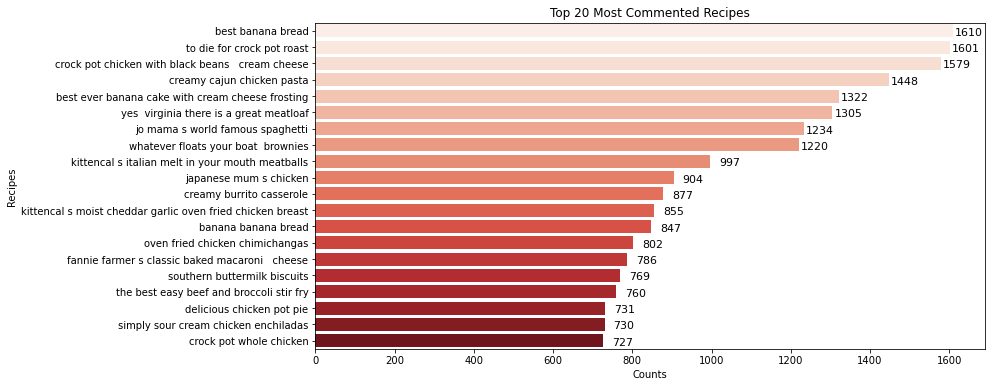

In [19]:
plt.figure(figsize=(12,6))
ax = sns.countplot(y = df['name'], order=df['name'].value_counts().index[:20], palette='Reds')
for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(30, -11), fontsize=11, color='black',textcoords='offset points',
                horizontalalignment='right')
plt.title('Top 20 Most Commented Recipes')
plt.xlabel('Counts')
plt.ylabel('Recipes')
plt.show()

**Best banana bread is the most commented recipe.**

## Contributor Analysis

In [20]:
# how many unique contributor are there ?

df['contributor_id'].nunique()

27691

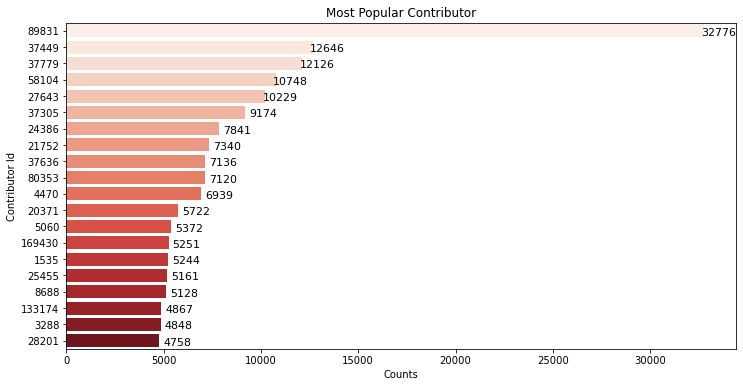

In [21]:
plt.figure(figsize=(12,6))
ax = sns.countplot(y=df['contributor_id'], order=df['contributor_id'].value_counts().index[:20], palette='Reds')
for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(32, -11), 
                fontsize=11,color='black', textcoords='offset points', horizontalalignment='right')
plt.title('Most Popular Contributor')
plt.xlabel('Counts')
plt.ylabel('Contributor Id')
plt.show()

**The contributor ID with the most comments on the recipe she/he submitted is 89831.**

## User Analysis

In [22]:
# how many unique user are there ? 

df['user_id'].nunique()

223166

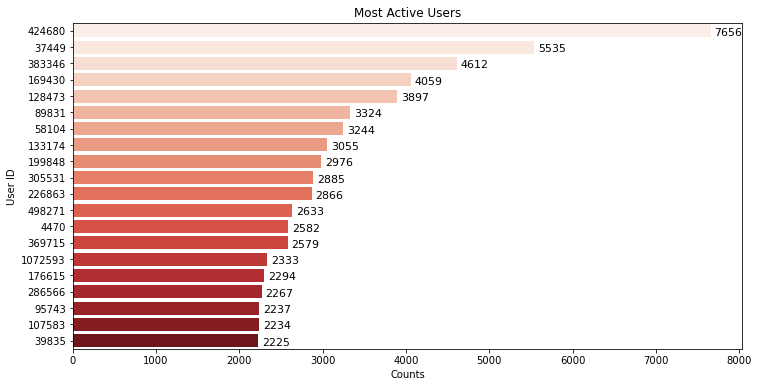

In [23]:
plt.figure(figsize=(12,6))
ax = sns.countplot(y=df['user_id'], order=df['user_id'].value_counts().index[:20], palette='Reds')
for p in ax.patches:
    ax.annotate(int(p.get_width()),((p.get_x() + p.get_width()), p.get_y()), xytext=(32, -11), 
                fontsize=11,color='black', textcoords='offset points', horizontalalignment='right')
plt.title('Most Active Users')
plt.xlabel('Counts')
plt.ylabel('User ID')
plt.show()

**Most active user id is 424680**

## Rating Analysis

**Rating - Nutritions Relationship**

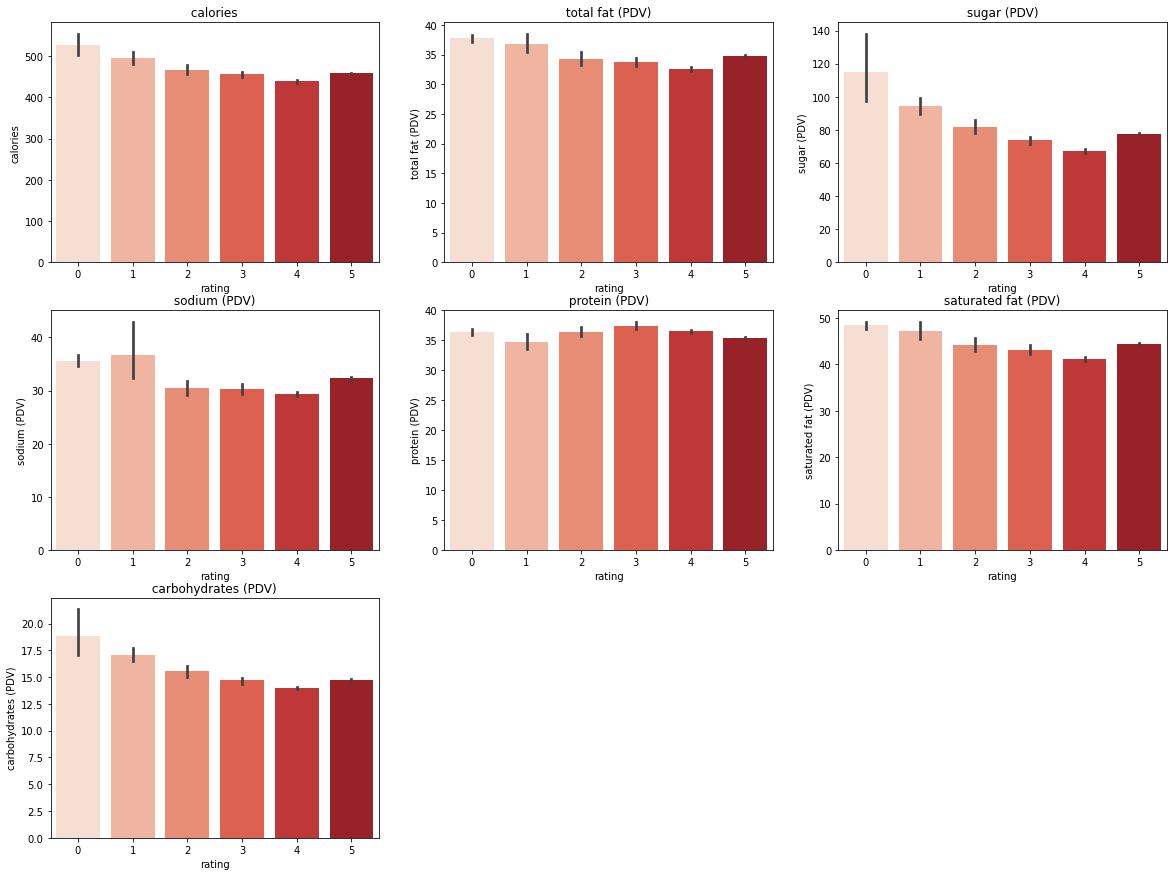

In [24]:
nutritions = ['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 
             'saturated fat (PDV)','carbohydrates (PDV)']

plt.figure(figsize=(20, 15))
for i, col in enumerate(nutritions):
    plt.subplot(3, 3, i+1)
    sns.barplot(y=col, x='rating', data=df, palette='Reds')
    plt.title(f" {col} ")
plt.show()

**As the nutritional values increase numerically, the ratings appear to decrease, but hypothesis tests can be applied to determine whether this is statistically significant.**

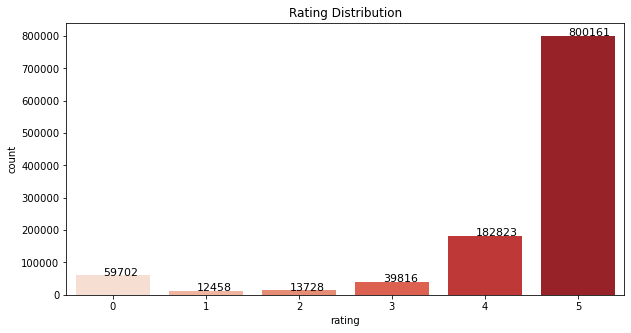

In [25]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='rating', data=df, palette='Reds')
for p in ax.patches:
    ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+50), fontsize=11)
plt.title('Rating Distribution')
plt.show()

**The percentage of users who gave 5 points to the recipes is quite high.**

In [26]:
df["date"].min(), df["date"].max()

(Timestamp('2000-01-25 00:00:00'), Timestamp('2018-12-20 00:00:00'))

In [27]:
df['year'] = df.date.dt.year

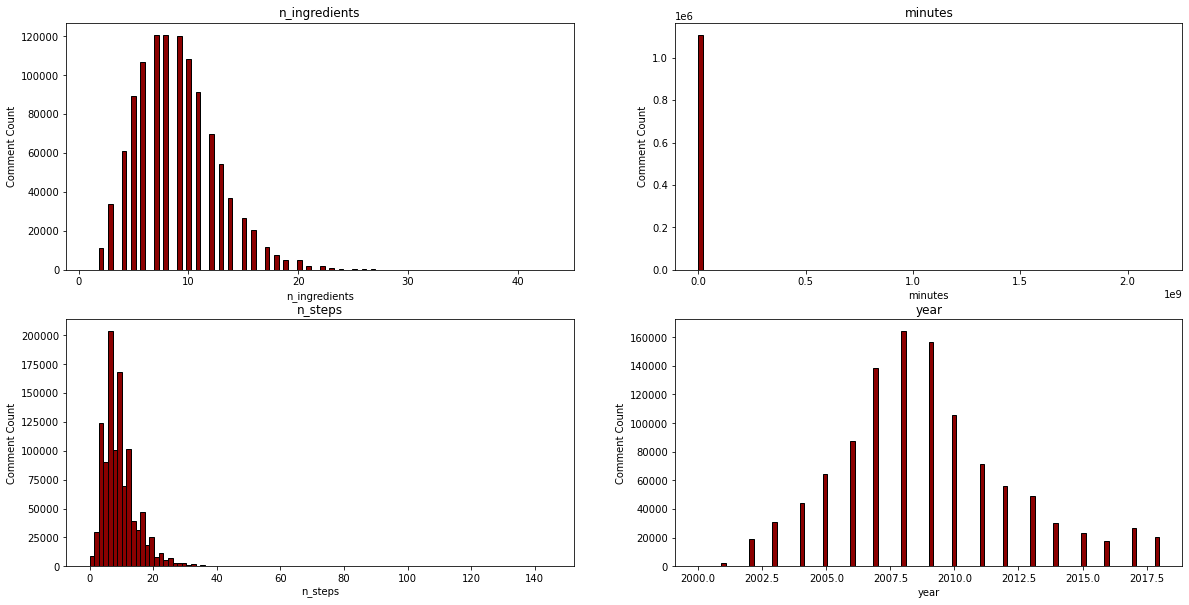

In [28]:
cols = ['n_ingredients', 'minutes', 'n_steps', 'year']

plt.figure(figsize=(20, 10))
for i, col in enumerate(cols):
    plt.subplot(2, 2, i+1)
    plt.hist(df[col], color='darkred', edgecolor='black',
         bins=100)
    plt.xlabel(f'{col}')
    plt.ylabel('Comment Count')
    plt.title(f'{col}');
plt.show()    

**The number of ingredients , the number of steps and minutes are quite right-skewed.**

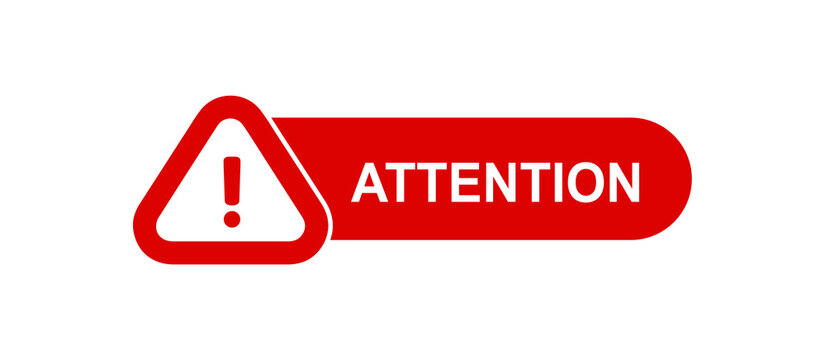

### ! The number of comments has been declining in recent years. 

## Text Analysis

In [29]:
df['name'] = df['name'].str.lower()
df['ingredients'] = df['ingredients'].str.lower()
df['steps'] = df['steps'].str.lower()
df['review'] = df['review'].str.lower()

In [30]:
df['name'] = df['name'].str.replace('[^\w\s]', '')
df['ingredients'] = df['ingredients'].str.replace('[^\w\s]', '')
df['steps'] = df['steps'].str.replace('[^\w\s]', '')
df['review'] = df['review'].str.replace('[^\w\s]', '')

In [31]:
df['name'] = df['name'].apply(lambda x: " ".join(x for x in str(x).split() if x not in ' s '))
df['review'] = df['review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in ' u '))

In [32]:
def create_wordcloud(dframe, col='ingredients', rating=False, name=False, max_words=100):
    # Create stopword list:
    stopwords = set(STOPWORDS)
    
    if rating:
        for rating in range(0,6):
            text = " ".join(i for i in dframe.loc[dframe['rating']==rating, col])
        
            print("Word Cloud for Rating: %s"%(rating))
            print('='*60)
       
            mask = np.array(Image.open("food.jpg"))
            wordcloud = WordCloud(stopwords=stopwords, background_color="black", mode="RGBA", max_words=max_words, mask=mask).generate(text)

            # Display the generated image:

            image_colors = ImageColorGenerator(mask)
            plt.figure(figsize=(20, 10))
            plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
            plt.axis("off")
            plt.show()

    else:
            text = " ".join(i for i in dframe[col])
            mask = np.array(Image.open("food.jpg"))
            wordcloud = WordCloud(stopwords=stopwords, background_color="black",mode="RGBA", max_words=max_words, mask=mask).generate(text)

            # Display the generated image:

            image_colors = ImageColorGenerator(mask)
            plt.figure(figsize=[20, 10])
            plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
            plt.axis("off")
            plt.show()

### The most common words in the name of the recipe

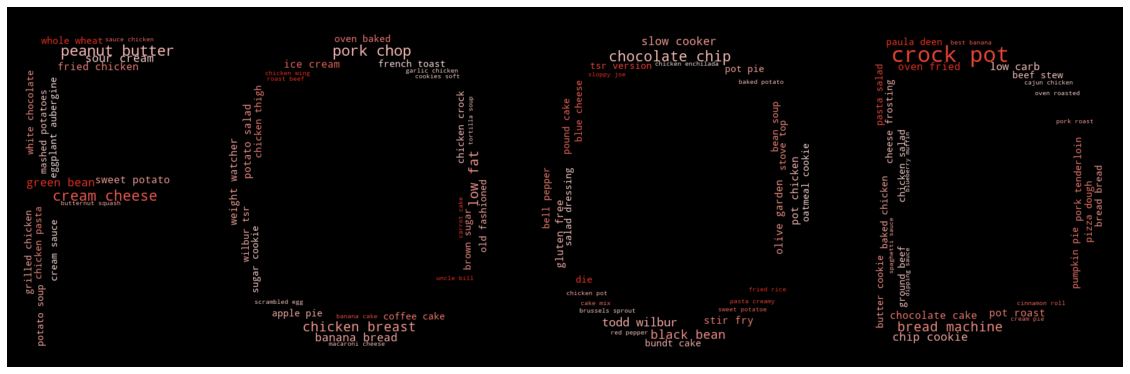

In [33]:
create_wordcloud(dframe=df, col='name')

### The most common words in the ingredients

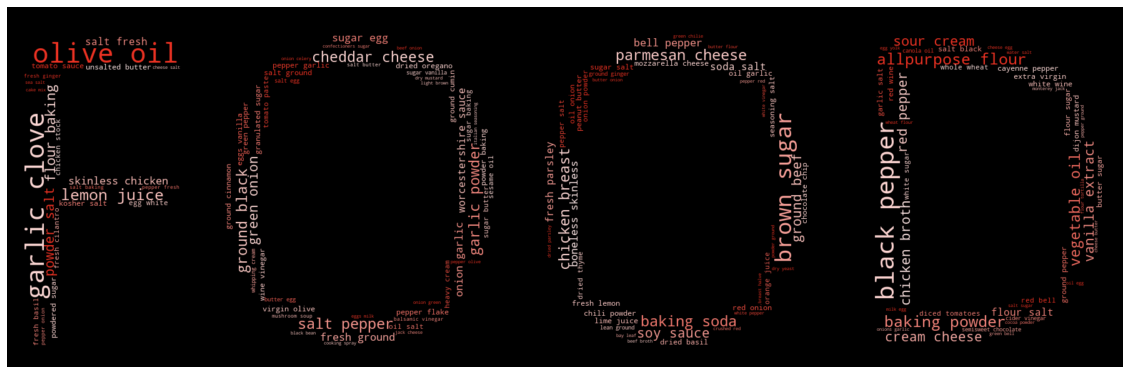

In [34]:
create_wordcloud(dframe=df, col='ingredients', max_words=150)

### The most common words in the steps

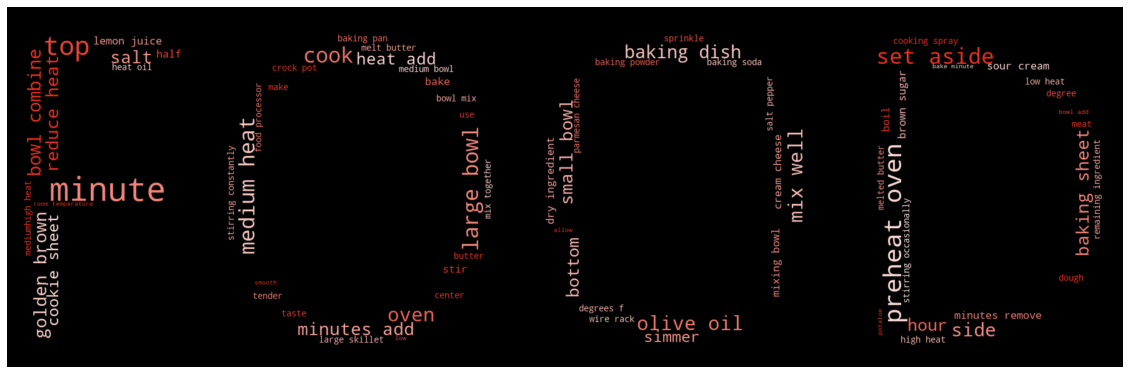

In [35]:
create_wordcloud(dframe=df, col='steps', max_words=75)

### The most common words in the reviews

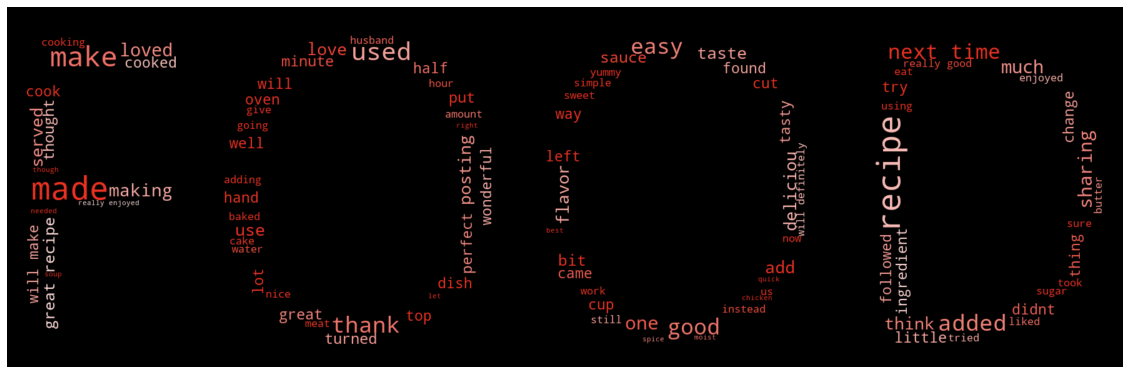

In [36]:
create_wordcloud(dframe=df, col='review')

## Sentiment Analysis 

In [37]:
sia = SentimentIntensityAnalyzer()

In [38]:
df["polarity_score"] = df["review"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [39]:
df["sentiment_label"] = df["review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

In [40]:
df["sentiment_label"].value_counts()

pos    1042102
neg      66586
Name: sentiment_label, dtype: int64

In [41]:
df.groupby("sentiment_label")[["rating"]].mean()

,rating
sentiment_label,
neg,3.06
pos,4.50


**It is seen that the average rating of the content with negative comments is quite low.**

## Outlier Analysis

In [42]:
df.describe([.05, .1, .25, .75, .95, .99]).T

,count,mean,std,min,5%,10%,25%,50%,75%,95%,99%,max
recipe_id,1108688.00,163684.76,130224.16,38.00,15826.00,26041.00,57497.00,124617.00,247616.25,427641.65,497021.00,537716.00
minutes,1108688.00,36916.48,8889932.33,0.00,5.00,10.00,21.00,40.00,70.00,305.00,960.00,2147483647.00
contributor_id,1108688.00,2703060.96,68338540.23,27.00,7802.00,20371.00,37636.00,91340.00,246482.00,795588.00,1701377.00,2002289981.00
n_steps,1108688.00,9.64,5.82,0.00,3.00,4.00,6.00,8.00,12.00,20.00,29.00,145.00
n_ingredients,1108688.00,8.96,3.70,1.00,4.00,5.00,6.00,9.00,11.00,16.00,20.00,43.00
user_id,1108688.00,139540210.30,503272042.48,1533.00,32570.00,53932.00,136979.00,333990.00,806997.00,2000299880.75,2001976150.47,2002372706.00
rating,1108688.00,4.41,1.26,0.00,0.00,3.00,4.00,5.00,5.00,5.00,5.00,5.00
calories,1108688.00,459.07,1035.09,0.00,64.10,97.50,176.40,312.60,512.60,1204.80,3087.86,434360.20
total fat (PDV),1108688.00,34.60,73.47,0.00,0.00,2.00,9.00,20.00,40.00,104.00,265.00,17183.00
sugar (PDV),1108688.00,78.11,640.64,0.00,1.00,2.00,9.00,24.00,67.00,252.00,1012.00,362729.00


In [43]:
2147483647.000 / 60 / 24 / 365 # :) 

4085.7755840943687

### A recipe prepared in 4085 years? Is it possible for a meal to contain 434360.20 calories?

### It is also clear that there are outliers in the data set. In addition, I'm really curious about the recipe containing 43 ingredients :)  

In [44]:
df[df['n_ingredients'] == 43]['name'].unique()

array(['a to z bread'], dtype=object)

In [45]:
df[df['n_ingredients'] == 43]['ingredients'].values[0]

'sugar vegetable oil eggs vanilla extract allpurpose flour cinnamon baking powder baking soda salt walnuts apples applesauce apricots bananas carrots cherries fresh coconut dates eggplants figs seedless grapes honey lemon juice marmalade mincemeat oranges peaches of fresh mint pears crushed pineapple prune canned pumpkin raisins raspberries rhubarb fresh strawberries frozen strawberries sweet potatoes tapioca tomatoes yams yogurt zucchini'

####  That's quite interesting. I will drop this observation because it is obvious that this observation is an outlier.

In [46]:
df = df[df['n_ingredients'] != 43]

#### For the whole dataset, my approach will be to thresh the outliers a bit so as not to break the structure of the dataset.

In [47]:
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable, q1=0.01, q3=0.99):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=q1, q3=q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [48]:
num_cols = [col for col in df.columns if df[col].dtypes != 'O']

In [49]:
num_cols = [col for col in num_cols if 'id' not in col ]

In [50]:
num_cols

['minutes',
 'submitted',
 'n_steps',
 'n_ingredients',
 'date',
 'rating',
 'calories',
 'total fat (PDV)',
 'sugar (PDV)',
 'sodium (PDV)',
 'protein (PDV)',
 'saturated fat (PDV)',
 'carbohydrates (PDV)',
 'year',
 'polarity_score']

In [51]:
for col in num_cols:
    print(f'Outlier check {col} : {check_outlier(df, col)}')

Outlier check minutes : True
Outlier check submitted : False
Outlier check n_steps : True
Outlier check n_ingredients : False
Outlier check date : False
Outlier check rating : False
Outlier check calories : True
Outlier check total fat (PDV) : True
Outlier check sugar (PDV) : True
Outlier check sodium (PDV) : True
Outlier check protein (PDV) : True
Outlier check saturated fat (PDV) : True
Outlier check carbohydrates (PDV) : True
Outlier check year : False
Outlier check polarity_score : False


In [52]:
for col in num_cols:
    if col in ['n_steps', 'n_ingredients']:
        replace_with_thresholds(df, col, q1=.05, q3=.95)
    else:
        replace_with_thresholds(df, col)

In [53]:
for col in num_cols:
    print(f'Outlier check {col} : {check_outlier(df, col)}')

Outlier check minutes : False
Outlier check submitted : False
Outlier check n_steps : False
Outlier check n_ingredients : False
Outlier check date : False
Outlier check rating : False
Outlier check calories : False
Outlier check total fat (PDV) : False
Outlier check sugar (PDV) : False
Outlier check sodium (PDV) : False
Outlier check protein (PDV) : False
Outlier check saturated fat (PDV) : False
Outlier check carbohydrates (PDV) : False
Outlier check year : False
Outlier check polarity_score : False


In [54]:
df.describe([.1, .25, .75, .9, .95, .99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,95%,99%,max
recipe_id,1108666.00,163687.93,130223.50,38.00,26049.00,57505.00,124623.00,247625.25,369413.50,427642.00,497021.00,537716.00
minutes,1108666.00,83.68,192.50,0.00,10.00,21.00,40.00,70.00,150.00,305.00,960.00,2397.00
contributor_id,1108666.00,2703114.57,68339217.21,27.00,20371.00,37636.00,91340.00,246482.00,512060.00,795588.00,1701377.00,2002289981.00
n_steps,1108666.00,9.62,5.69,0.00,4.00,6.00,8.00,12.00,17.00,20.00,29.00,45.50
n_ingredients,1108666.00,8.96,3.69,1.00,5.00,6.00,9.00,11.00,14.00,16.00,20.00,34.00
user_id,1108666.00,139541165.59,503273561.98,1533.00,53932.00,136979.00,333990.00,806997.00,2175495.00,2000299892.25,2001976140.20,2002372706.00
rating,1108666.00,4.41,1.26,0.00,3.00,4.00,5.00,5.00,5.00,5.00,5.00,5.00
calories,1108666.00,452.22,598.21,0.00,97.50,176.40,312.60,512.60,832.20,1204.80,3087.98,7690.99
total fat (PDV),1108666.00,33.89,53.12,0.00,2.00,9.00,20.00,40.00,70.00,104.00,265.00,662.50
sugar (PDV),1108666.00,75.41,196.34,0.00,2.00,9.00,24.00,67.00,157.00,252.00,1012.00,2530.00
